### Done by Veronika Karpushenkova

worked on server /home/Veronika.Karpushenko/final_project/rnaseq

to save some space I will turn down warning notifications in cell output:

In [166]:
options(warn = -1)

### Task:<br>
The RNA-seq data will be used to find a correlation between the level of gene expression and methylation patterns. 
We will use DESeq2 to analyze differential expression, basic method of normalisation will be used (median-of-ratios). 
But before that, it will be necessary to make an annotation. Since we have salmon files ready, it will be necessary to match the transcript with the corresponding gene.
For clusterization and further visualisation we will do regularized log normalisation to minimise the noise and stabilize dispersion.


### Uploading packages

In [167]:
library(dplyr)
library(ggplot2)
library(DESeq2)
library(DOSE)
library(pheatmap)
library(tibble)
library(clusterProfiler)
library(DT)
library(rtracklayer)
library(tximport)
library(org.Hs.eg.db)
library(EnhancedVolcano)
library(KEGG.db)
library(msigdbr)
library(cluster)
library(factoextra)

### Uploading files

We have RNA-seq files (salmon, transcriptome - gencode v46 or Ensembl v114) <br>
iPSC-derived: GSE212252 (3 replicates)<br>
Post-mortem: GSE96615 (3 replicates)<br>



The files:<br>
CULTURE_SRR21307327_Zaghi.sf  CULTURE_SRR21307381_Zaghi.sf   PM_BA9_SRR5343882_Rizzardi.sf  PM_BA9_SRR5343889_Rizzardi.sf  PM_BA9_SRR5343896_Rizzardi.sf
CULTURE_SRR21307379_Zaghi.sf  PM_BA9_SRR5343878_Rizzardi.sf  PM_BA9_SRR5343886_Rizzardi.sf  PM_BA9_SRR5343892_Rizzardi.sf

In [5]:
#PM corresponds to post-mortem, and CULTURE corresponds to iPSC-derived
files <- c(
  "data/CULTURE_SRR21307327_Zaghi.sf",
  "data/CULTURE_SRR21307381_Zaghi.sf",
  "data/CULTURE_SRR21307379_Zaghi.sf",
  "data/PM_BA9_SRR5343878_Rizzardi.sf",
  "data/PM_BA9_SRR5343882_Rizzardi.sf",
  "data/PM_BA9_SRR5343886_Rizzardi.sf",
  "data/PM_BA9_SRR5343889_Rizzardi.sf",
  "data/PM_BA9_SRR5343892_Rizzardi.sf",
  "data/PM_BA9_SRR5343896_Rizzardi.sf"
)
sample_names <- c(
  "CULTURE_327", "CULTURE_381", "CULTURE_379",
  "PM_878", "PM_882", "PM_886", "PM_889", "PM_892", "PM_896"
)

# create a sample table
sample_table <- data.frame(
  sample = sample_names,
  file = files
)

In [6]:
names(files) <- sample_names

In [7]:
head(sample_table)

sample      file                              
1 CULTURE_327 data/CULTURE_SRR21307327_Zaghi.sf 
2 CULTURE_381 data/CULTURE_SRR21307381_Zaghi.sf 
3 CULTURE_379 data/CULTURE_SRR21307379_Zaghi.sf 
4 PM_878      data/PM_BA9_SRR5343878_Rizzardi.sf
5 PM_882      data/PM_BA9_SRR5343882_Rizzardi.sf
6 PM_886      data/PM_BA9_SRR5343886_Rizzardi.sf

In [10]:
# read one .sf file to get transcript IDs
library(readr)
sf_example <- read_tsv(files[1])
head(sf_example)

Rows: 192825 Columns: 5
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): Name
dbl (4): Length, EffectiveLength, TPM, NumReads

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Name              Length EffectiveLength TPM NumReads
1 ENST00000415118.1  8      9              0   0       
2 ENST00000448914.1 13     14              0   0       
3 ENST00000434970.2  9     10              0   0       
4 ENST00000631435.1 12     13              0   0       
5 ENST00000710614.1 16     17              0   0       
6 ENST00000605284.1 17     18              0   0

Accordong to the IDs above our genome transcriptome is Ensembl v114

I donloaded Homo_sapiens.GRCh38.113.gtf.gz:<br>
`wget https://ftp.ensembl.org/pub/release-114/gtf/homo_sapiens/Homo_sapiens.GRCh38.114.gtf.gz`

In [13]:
gtf_file <- "Homo_sapiens.GRCh38.114.gtf.gz"

gtf <- import(gtf_file)

# extract transcript-to-gene mapping
tx2gene <- unique(as.data.frame(mcols(gtf[gtf$type == "transcript", c("transcript_id", "gene_id")])))

# remove version numbers to match .sf IDs
tx2gene$transcript_id <- sub("\\..*", "", tx2gene$transcript_id)

# save mapping
write.csv(tx2gene, "tx2gene.csv", row.names = FALSE)

In [15]:
tx2gene <- read.csv("tx2gene.csv")

We will make a list containing matrices for counts, abundances, and lengths at the gene level, which can be used for downstream differential expression analysis:

In [16]:
txi <- tximport(files, type = "salmon", tx2gene = tx2gene, ignoreTxVersion = TRUE)

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 


transcripts missing from tx2gene: 14374

summarizing abundance

summarizing counts

summarizing length



In [17]:
colnames(txi$counts)

[1] "CULTURE_327" "CULTURE_381" "CULTURE_379" "PM_878"      "PM_882"     
[6] "PM_886"      "PM_889"      "PM_892"      "PM_896"

We need a meta table which maps our samples to the corresponding sample groups that we are investigating. Our metadata will include three columns: “Genotype”, “sample” and “SampleID”.

In [18]:
meta <- data.frame(sample = sample_names) %>%
  mutate(
    Genotype = sapply(strsplit(sample, "_"), `[`, 1),
    SampleID = sapply(strsplit(sample, "_"), `[`, 2)
  )
knitr::kable(meta)



|sample      |Genotype |SampleID |
|:-----------|:--------|:--------|
|CULTURE_327 |CULTURE  |327      |
|CULTURE_381 |CULTURE  |381      |
|CULTURE_379 |CULTURE  |379      |
|PM_878      |PM       |878      |
|PM_882      |PM       |882      |
|PM_886      |PM       |886      |
|PM_889      |PM       |889      |
|PM_892      |PM       |892      |
|PM_896      |PM       |896      |

### DESeq2 object

In [19]:
rownames(meta) <- sample_names

In [20]:
meta

sample      Genotype SampleID
CULTURE_327 CULTURE_327 CULTURE  327     
CULTURE_381 CULTURE_381 CULTURE  381     
CULTURE_379 CULTURE_379 CULTURE  379     
PM_878      PM_878      PM       878     
PM_882      PM_882      PM       882     
PM_886      PM_886      PM       886     
PM_889      PM_889      PM       889     
PM_892      PM_892      PM       892     
PM_896      PM_896      PM       896

To create DESeq2 object we will need the count matrix and the metadata table as input. We will also need to specify a design formula. The design formula specifies the column(s) in the metadata table and how they should be used in the analysis. For our dataset we only have one column we are interested in, that is  ~ Genotype.

In [30]:
dds <- DESeqDataSetFromTximport(txi, colData = meta, design = ~ Genotype)

# filter out genes with low counts
keep <- rowSums(counts(dds)) > 10
dds <- dds[keep, ]
dds <- DESeq(dds)

using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [31]:
dds

class: DESeqDataSet 
dim: 23483 9 
metadata(1): version
assays(6): counts avgTxLength ... H cooks
rownames(23483): ENSG00000000003 ENSG00000000005 ... ENSG00000310560
  ENSG00000310576
rowData names(22): baseMean baseVar ... deviance maxCooks
colnames(9): CULTURE_327 CULTURE_381 ... PM_892 PM_896
colData names(3): sample Genotype SampleID

### Normalization

Now we will normalize the count data in order to be able to make fair gene comparisons between samples. We will ise the median of ratios method of normalization

In [37]:
sf <- estimateSizeFactorsForMatrix(txi$counts)
sizeFactors(dds) <- sf

In [38]:
sizeFactors(dds)

CULTURE_327 CULTURE_381 CULTURE_379      PM_878      PM_882      PM_886 
  1.0223145   0.6719129   0.9901765   1.0443086   1.5029801   0.8523914 
     PM_889      PM_892      PM_896 
  1.1408942   0.8064402   1.3653453

In [39]:
normalized_counts <- counts(dds, normalized=TRUE)
head(normalized_counts)

CULTURE_327 CULTURE_381 CULTURE_379 PM_878     PM_882   
ENSG00000000003 1315.1218   1311.70936  1387.006203 105.474607  27.12929
ENSG00000000005   30.4428     26.95968    22.924633   5.052421  15.03105
ENSG00000000419 1981.3614   2015.83890  2096.573597 592.896670 656.13703
ENSG00000000457 1411.1584   1444.24291  1262.574474 734.895553 584.22999
ENSG00000000460  824.2443    818.94785   875.480495 536.184248 487.95587
ENSG00000000938   27.4213     16.52287     8.564975   8.452427   0.00000
                PM_886     PM_889   PM_892     PM_896    
ENSG00000000003 249.587051 172.3374 341.573744 242.691535
ENSG00000000005   0.000000   0.0000   4.177684   5.764415
ENSG00000000419 861.614995 771.3531 918.146060 682.117333
ENSG00000000457 451.403830 610.2279 325.478831 735.425811
ENSG00000000460 411.587940 324.3556 282.767203 278.231930
ENSG00000000938   6.075086   0.0000   0.000000   0.000000

### Quality control

We perform QC checks on the count data to help us ensure that the samples/replicates look good.

First, let’s try the most simple method of log2 transformation and plot counts of the two CULTURE replicates as a scatter plot:

In [40]:
# extract normalized counts
nts <- counts(dds, normalized = TRUE)

# log2 transform
nts_log2 <- log2(nts + 1)

# convert to data frame
df <- as.data.frame(nts_log2)

# check your column names
print(colnames(df))

[1] "CULTURE_327" "CULTURE_381" "CULTURE_379" "PM_878"      "PM_882"     
[6] "PM_886"      "PM_889"      "PM_892"      "PM_896"     


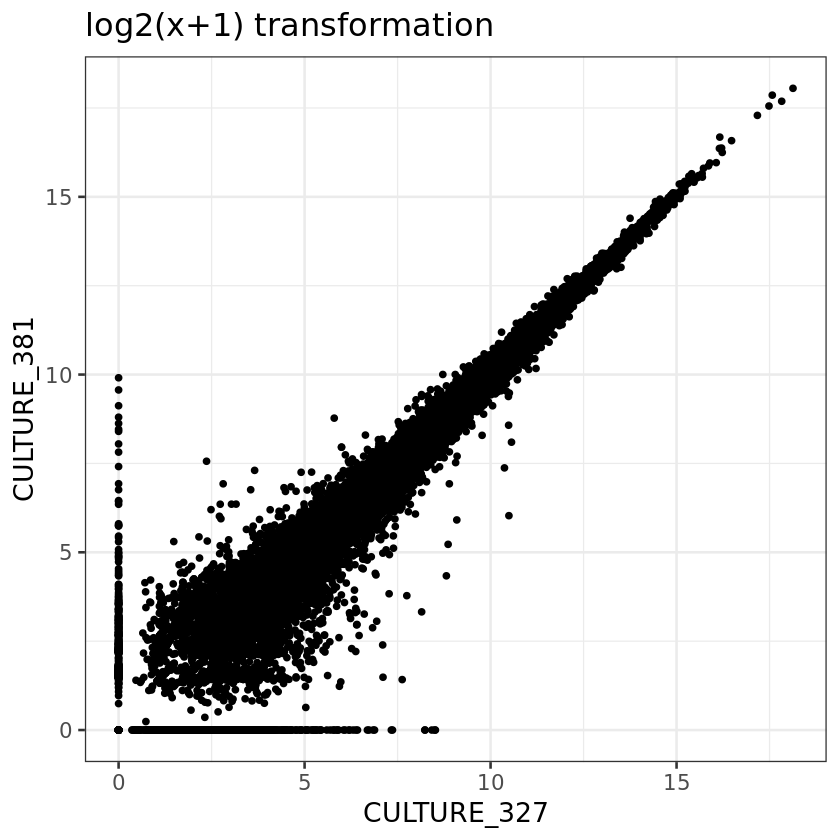

In [41]:
# plot
ggplot(df, aes(x = CULTURE_327, y = CULTURE_381)) + 
    geom_point() +
    ggtitle('log2(x+1) transformation') +
    theme_bw(base_size = 16)

Above we can see heteroscedasticity in the data, illustrating the dependence of the variance on the mean count value.

Let's apply a regularized log transform (rlog) of the normalized counts for sample-level QC as it moderates the variance across the mean, improving the clustering:

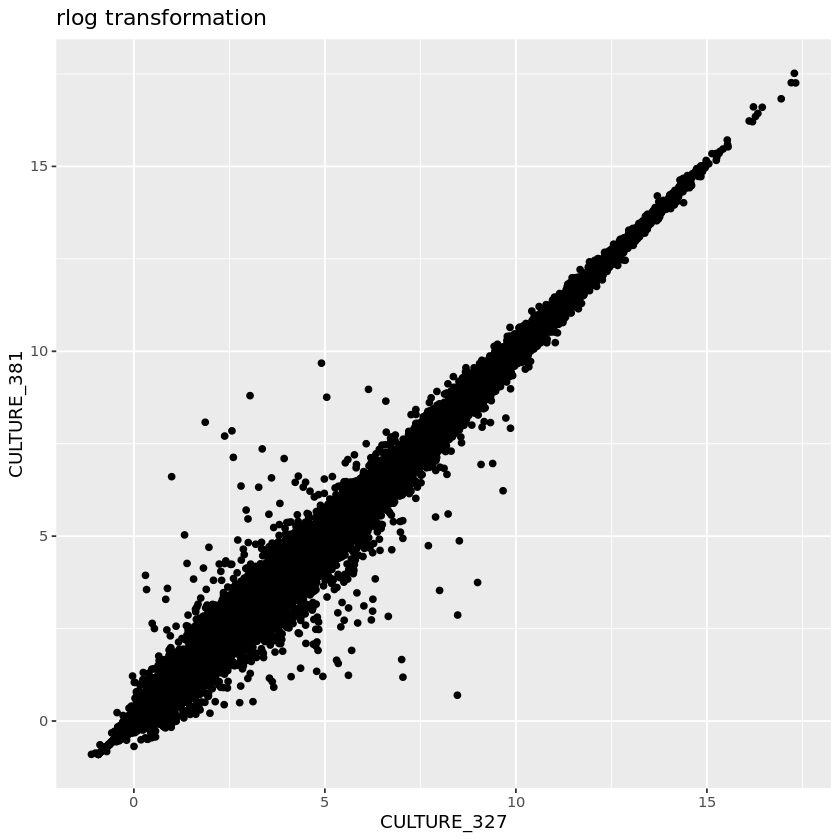

In [42]:
rld <- rlog(dds, blind=TRUE)
ggplot(as.data.frame(assay(rld)), aes(x = CULTURE_327, y = CULTURE_381)) + 
    geom_point() +
    ggtitle('rlog transformation')

### Principal Component Analysis (PCA)

In [43]:
plotPCA.mystyle <- function (object, meta, ntop = 500, returnData = FALSE)
{
    font.size <- 18
    rv <- rowVars(assay(object))
    select <- order(rv, decreasing = TRUE)[seq_len(min(ntop, length(rv)))]
    pca <- prcomp(t(assay(object)[select, ]))
    percentVar <- pca$sdev^2/sum(pca$sdev^2)
    
    d1 <- data.frame(
        PC1 = pca$x[, 1], 
        PC2 = pca$x[, 2], 
        Genotype = meta$Genotype,
        name = rownames(meta)
    )
    
    ggplot(data = d1, aes(x = PC1, y = PC2)) +
        geom_point(aes(color = Genotype), size = 6) + 
        xlab(paste0("PC1: ", round(percentVar[1] * 100), "% variance")) + 
        ylab(paste0("PC2: ", round(percentVar[2] * 100), "% variance")) +
        theme_dose(font.size = font.size) +
        theme(
            legend.key = element_rect(colour = NA, fill = NA), 
            legend.title= element_blank(), 
            legend.text=element_text(size=font.size-2)
        )
}

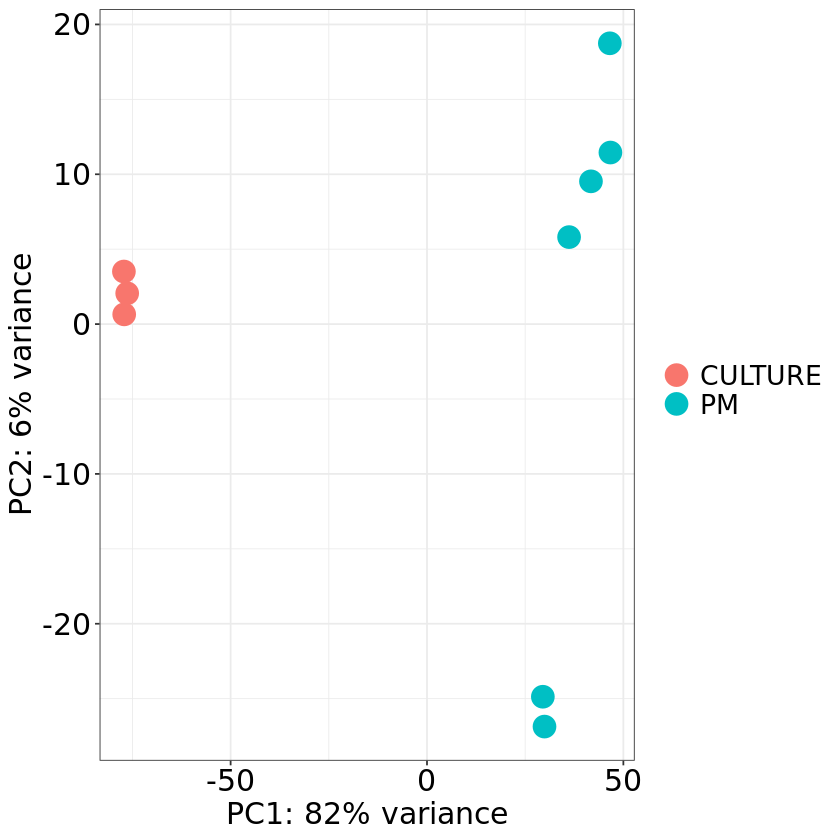

In [44]:
plotPCA.mystyle(rld, meta)

In [45]:
plotPCA.mystyle <- function (object, meta, ntop = 500, returnData = FALSE)
{
    font.size <- 18
    rv <- rowVars(assay(object))
    select <- order(rv, decreasing = TRUE)[seq_len(min(ntop, length(rv)))]
    pca <- prcomp(t(assay(object)[select, ]))
    percentVar <- pca$sdev^2/sum(pca$sdev^2)
    
    d1 <- data.frame(
        PC1 = pca$x[, 1], 
        PC3 = pca$x[, 3], 
        Genotype = meta$Genotype,
        name = rownames(meta)
    )
    
    ggplot(data = d1, aes(x = PC1, y = PC3)) +
        geom_point(aes(color = Genotype), size = 6) + 
        xlab(paste0("PC1: ", round(percentVar[1] * 100), "% variance")) + 
        ylab(paste0("PC3: ", round(percentVar[3] * 100), "% variance")) +
        theme_dose(font.size = font.size) +
        theme(
            legend.key = element_rect(colour = NA, fill = NA), 
            legend.title= element_blank(), 
            legend.text=element_text(size=font.size-2)
        )
}

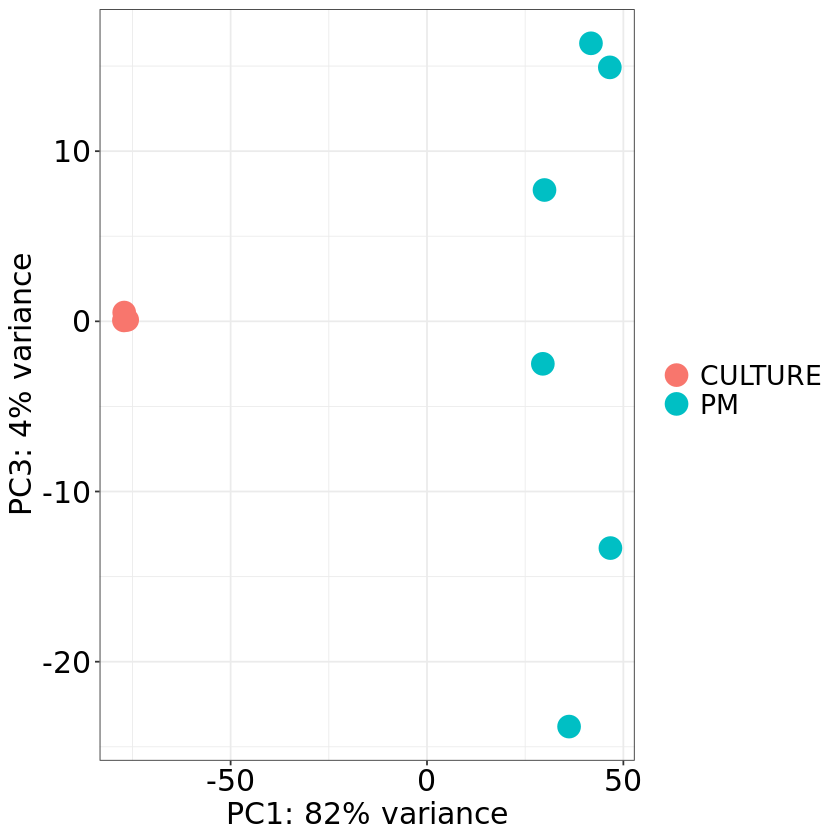

In [46]:
plotPCA.mystyle(rld, meta)

Those above are PCA plots which might show and emphasize variations and strong patterns. We can see that clustering is quite obvious, and we can see that biological replicates cluster together on PC1 (82% of variance explained), and the samples from different treatment groups cluster separately.The percantage of variance corresponds to the amount of variation captured by the principal component. Post-mortem samples have bigger variance on PC2 and PC3, than culture samples which is due to biological heterogeneity (time after death, tissue degradation, and individual biological variability), and technical heterogeneity (degradation, differences in sample handling, or batch effects) of post-mortem samples.

### Correlation Heatmap

In [47]:
rld_mat <- assay(rld)

In [48]:
rld_cor <- cor(rld_mat)

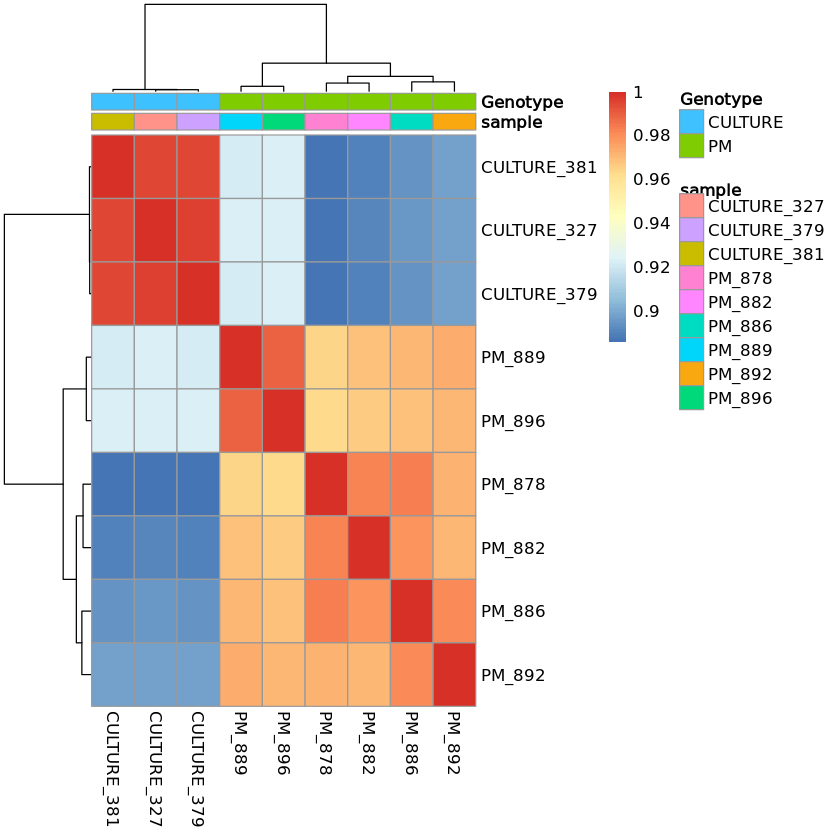

In [49]:
pheatmap(rld_cor, annotation = meta[,c(1,2)])

As expected, correlation between culture samples is really high. PM samples also correlate really well, and bigger correlation is seen between replicates.

### Differential testing

We have one factor (Genotype) but let's copy it into distant column

In [58]:
meta$Factors <- meta$Genotype 
meta$Factors <- factor(meta$Factors, levels = unique(meta$Factors))

In [61]:
dds_factors <- DESeqDataSetFromTximport(txi, colData = meta, design = ~ Factors)

using counts and average transcript lengths from tximport



### DE analysis

In [62]:
dds_analysis <- DESeq(dds_factors)


estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



Let's plot dispersion estimates:

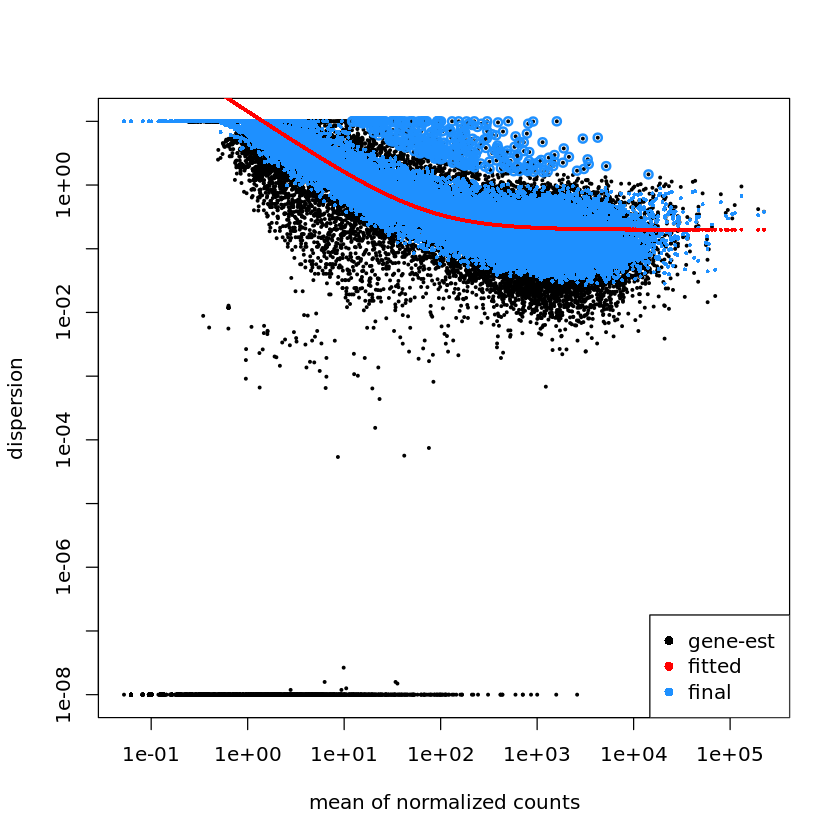

In [63]:
plotDispEsts(dds_analysis)

To tell DESeq2 which groups we wish to compare, we supply the contrasts we would like to make using the contrast argument.

In [64]:
contrast_pm_vs_culture <- c("Factors", "PM", "CULTURE")

In [65]:
res_unshrunken_pm_vs_culture <- results(dds_analysis, contrast = contrast_pm_vs_culture, alpha = 0.05)

To generate more accurate log2 fold change estimates, we will shrink the log2 fold changes estimates toward zero when the information for a gene is low.

In [76]:
res_pm_vs_culture <- lfcShrink(dds_analysis, 
                               contrast = contrast_pm_vs_culture, 
                               res = res_unshrunken_pm_vs_culture, 
                               type = "normal")

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895



In [77]:
knitr::kable(head(res_pm_vs_culture))



|                |    baseMean| log2FoldChange|     lfcSE|      stat|    pvalue|      padj|
|:---------------|-----------:|--------------:|---------:|---------:|---------:|---------:|
|ENSG00000000003 |  572.514554|      -2.757133| 0.5821881| -4.735112| 0.0000022| 0.0000094|
|ENSG00000000005 |   12.261410|      -2.201704| 1.0369156| -2.120160| 0.0339925| 0.0590397|
|ENSG00000000419 | 1175.115454|      -1.438254| 0.2348224| -6.124895| 0.0000000| 0.0000000|
|ENSG00000000457 |  839.959754|      -1.250333| 0.3197326| -3.910558| 0.0000921| 0.0002921|
|ENSG00000000460 |  537.750606|      -1.110226| 0.3106795| -3.573594| 0.0003521| 0.0009824|
|ENSG00000000938 |    7.448517|      -2.471943| 1.4383665| -1.709865| 0.0872908| 0.1334243|

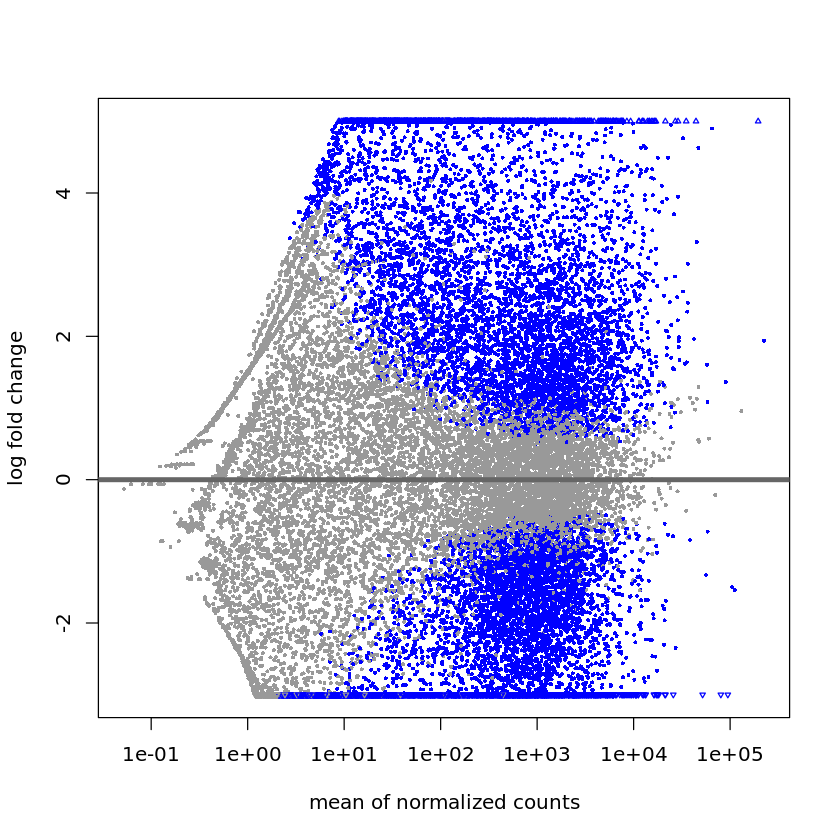

In [78]:
plotMA(res_pm_vs_culture, ylim = c(-3, 5))

Let's also plot the unshrunken results.

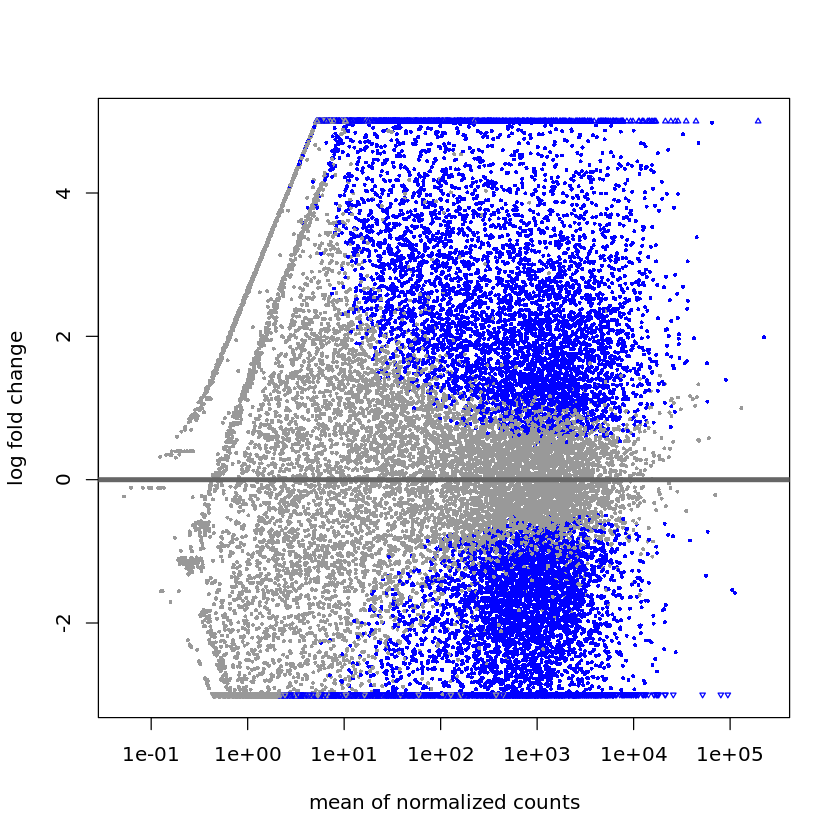

In [79]:
plotMA(res_unshrunken_pm_vs_culture, ylim = c(-3, 5))

Here unshrunken data is little bit more dispersed, and noisy.

In [80]:
summary(res_pm_vs_culture, alpha = 0.05)


out of 28292 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 6372, 23%
LFC < 0 (down)     : 6621, 23%
outliers [1]       : 243, 0.86%
low counts [2]     : 4883, 17%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



### Extracting significant genes

Now we will extract significant differentially expressed genes. We will define significant genes as those satisfying the |FDR p-value < 0.05| and |log2(Fold Change)| > 0.58:

In [86]:
padj.cutoff <- 0.05
lfc.cutoff <- 0.58

res_pm_vs_culture_tb <- res_pm_vs_culture %>%
  data.frame() %>%
  rownames_to_column(var = "gene") %>%
  as_tibble()

sig_pm_vs_culture <- res_pm_vs_culture_tb %>%
  dplyr::filter(padj < padj.cutoff & abs(log2FoldChange) >= lfc.cutoff)

In [87]:
knitr::kable(head(sig_pm_vs_culture))



|gene            |  baseMean| log2FoldChange|     lfcSE|      stat|    pvalue|      padj|
|:---------------|---------:|--------------:|---------:|---------:|---------:|---------:|
|ENSG00000000003 |  572.5146|     -2.7571332| 0.5821881| -4.735112| 0.0000022| 0.0000094|
|ENSG00000000419 | 1175.1155|     -1.4382535| 0.2348224| -6.124895| 0.0000000| 0.0000000|
|ENSG00000000457 |  839.9598|     -1.2503335| 0.3197326| -3.910558| 0.0000921| 0.0002921|
|ENSG00000000460 |  537.7506|     -1.1102258| 0.3106795| -3.573594| 0.0003521| 0.0009824|
|ENSG00000001036 |  536.6069|     -3.2073107| 0.5176828| -6.194693| 0.0000000| 0.0000000|
|ENSG00000001084 |  787.0533|     -0.7939098| 0.3461836| -2.293329| 0.0218291| 0.0400770|

Number of significant genes:

In [92]:
nrow(sig_pm_vs_culture)

[1] 12971

In [93]:
summary(res_pm_vs_culture, alpha = 0.05)


out of 28292 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 6372, 23%
LFC < 0 (down)     : 6621, 23%
outliers [1]       : 243, 0.86%
low counts [2]     : 4883, 17%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



### Gene annotation

To perform Gene ID conversion we will use human genome annotation from org.Hs.eg.db package. We use select() function to convert ENSEMBL IDs to gene names (“SYMBOL”) and Entrez identifiers (“ENTREZID”)

In [98]:
mm <- org.Hs.eg.db
my.symbols <- res_pm_vs_culture_tb$gene 
map <- select(mm,
              keys = my.symbols,
              columns = c("ENTREZID", "SYMBOL", "ENSEMBL"),
              keytype = "ENSEMBL")

'select()' returned 1:many mapping between keys and columns



First, we will combine DE result tables with the obtained gene annotation:

In [100]:
res_pm_vs_culture_tb <- left_join(res_pm_vs_culture_tb, map, by = c("gene" = "ENSEMBL"))

In [101]:
datatable(head(res_pm_vs_culture_tb))

HTML widgets cannot be represented in plain text (need html)

Next, we get rid of duplicated ENSEMBL IDs:

In [102]:
res_pm_vs_culture_tb <- res_pm_vs_culture_tb[!duplicated(res_pm_vs_culture_tb$gene),]

Finally, we get the annotation only for the differentially expressed genes:

In [103]:
sig_pm_vs_culture <- res_pm_vs_culture_tb %>% filter(gene %in% sig_pm_vs_culture$gene)

### Visualization: Volcano plot

This plot shows the direction of gene expression changes (up- or down-regulated) and also highlight the top DE genes.

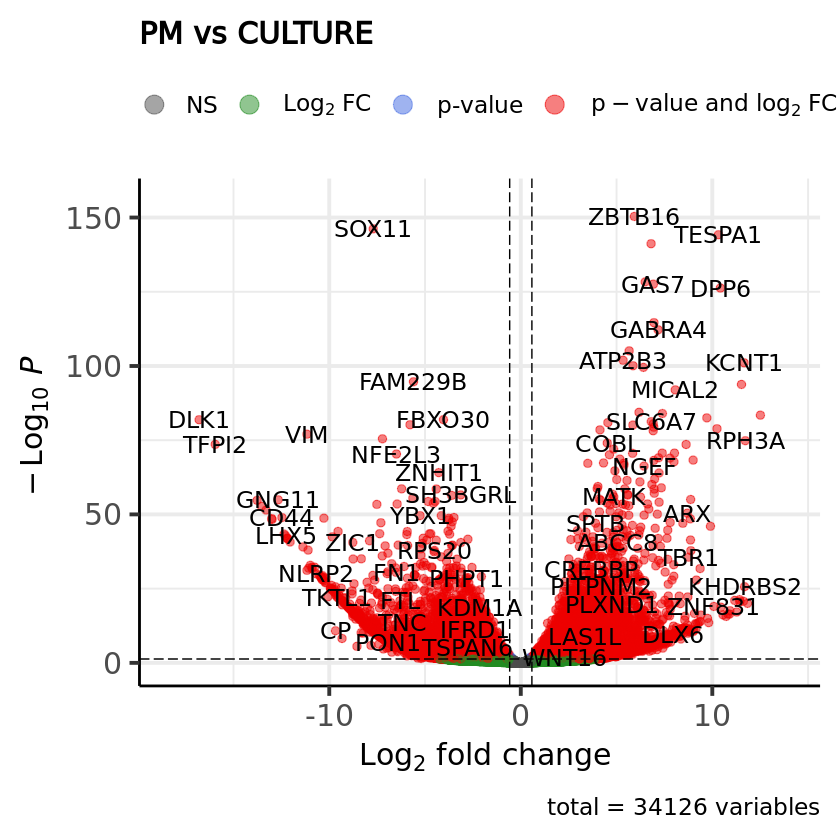

In [107]:
p1 <- EnhancedVolcano(res_pm_vs_culture_tb,
        lab = res_pm_vs_culture_tb$SYMBOL, 
        x = 'log2FoldChange',
        y = 'padj', 
        title = 'PM vs CULTURE',
        subtitle = NULL,
        pCutoff = 0.05, 
        FCcutoff = 0.58)

p1

Each point on volcano plot is a DE gene.<br>On x-axis negative values correspond to genes more highly expressed in culture, and positive values correspond to genes more highly expressed in post-mortem samples.<br>On y-axis higher value corrsponds to more statistically significant result (lower p-value).<br>Red dots correspond to genes statistically significant (by p-value) and have a large fold change. Grey are not significant results, blues are significant only by p-value, and greens are significant only by fold change.<br>
So, SOX11, FAM229B, VIM, DLK1, etc. are significant DE genes for culture samples.<br>
Meanwhile, ZBTB16M TESPA1, GAS7, DPP6, GABRA4, etc. are significant DE genes for post-mortem samples.

### Heatmap of significant genes

We convert normalized_counts to a data frame and transfer the row names to a new column called “gene”

In [111]:
normalized_counts <- counts(dds_analysis, normalized = T) %>%
                data.frame() %>%
                rownames_to_column(var="gene")

We extract normalized expression for significant genes:

In [112]:
norm_sig_pm_vs_culture <- normalized_counts %>%
                filter(gene %in% sig_pm_vs_culture$gene) %>% column_to_rownames('gene')

We plot the heatmap

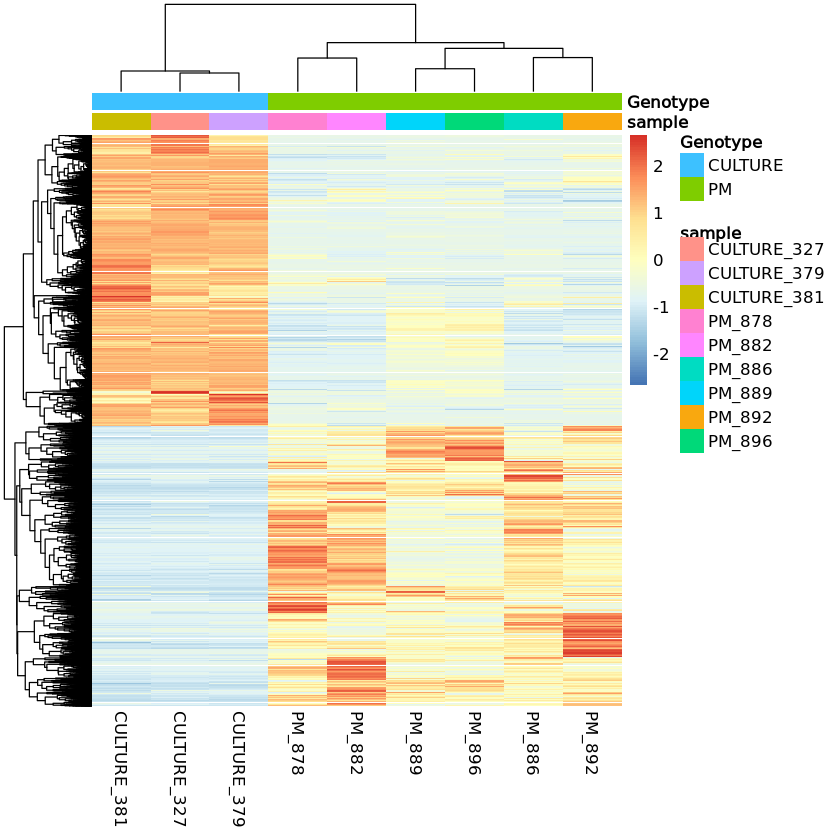

In [113]:
pheatmap(norm_sig_pm_vs_culture, 
                cluster_rows = T,
                show_rownames = F,
                annotation = meta[,c(1,2)],
                border_color = NA,
                fontsize = 10,
                scale = "row",
                fontsize_row = 10,
                height = 10)

Here also we can see quite high and clear clusterization between culture samples. Same for post-mortem samples with a little bit less correlation, and between replicates correlation is higher than between samples.

### Comparison with cortical layer markers

Let's analyze cortical layer marker expression in iPSC-derived neurons

According to:<br>
https://www.pnas.org/doi/10.1073/pnas.1216793109<br>
https://pubmed.ncbi.nlm.nih.gov/21228164/<br>
Cortical layer markers: Tbr1, Ctip2, and Satb2 are expressed in postmitotic neurons, Fezf2 is expressed in cycling cortical progenitors from very early stages of corticogenesis.  Fezf2 blocks corticothalamic fate in layer 5 by reducing Tbr1 expression in subcerebral neurons<br>
According to:<br>
https://www.pnas.org/doi/10.1073/pnas.1216793109<br>
Tbr1, EphA4, and Unc5H3 are critical downstream targets of Satb2 in callosal fate specification. This represents a unique role for Tbr1, implicated previously in specifying corticothalamic projections. We further show that Tbr1 expression is dually regulated by Satb2 and Ctip2 in layers 2–5.<br>
According to:<br>
https://www.bio-connect.nl/news/cortical-layers/<br>
LHX2 and PAX6 together play a crucial role in the specification of neo-cortical progenitors which give rise to the projection neurons. MEF2C is another example of transcription factor essential for normal neural development and spatial distribution in the neocortex.<br>
Upper layers neurons can be identified by expression of CUX1 and POU3F2 (BRN2), the neurons of layer V – by expression of BCL11B (CTIP2) and neurons of layer VI – by FOXP2 expression<br>

Summary:<br>
-Deep layers (V–VI): Tbr1, Fezf2, Ctip2<br>

-Upper layers (II–IV): Satb2, Cux1, Pou3f2 (Brn2)

-Pan-neuronal markers: Map2 (maturation), Syt1 (synaptic), Gria2 (glutamatergic)

In [116]:
genes <- c('TBR1', 'FEZF2', 'CTIP2', 'SATB2', 'CUX1', 'POU3F2', 'BRN2', 'MAP2', 'SYT1', 'HEXB', 'CST3', 'GRIA2')
genes_ENSEMBL <- filter(map, SYMBOL %in% genes)$ENSEMBL
genes_ENSEMBL

[1] "ENSG00000049860" "ENSG00000067715" "ENSG00000078018" "ENSG00000101439"
 [5] "ENSG00000119042" "ENSG00000120251" "ENSG00000136535" "ENSG00000153266"
 [9] "ENSG00000184486" "ENSG00000257923"

In [117]:
genes_filtered <- filter(map, ENSEMBL %in% genes_ENSEMBL)$SYMBOL
genes_filtered

[1] "HEXB"   "SYT1"   "MAP2"   "CST3"   "SATB2"  "GRIA2"  "TBR1"   "FEZF2" 
 [9] "POU3F2" "CUX1"

In [118]:
datatable(head(res_pm_vs_culture_tb))

HTML widgets cannot be represented in plain text (need html)

In [119]:
head(sig_pm_vs_culture)

gene            baseMean  log2FoldChange lfcSE     stat      pvalue      
1 ENSG00000000003  572.5146 -2.7571332     0.5821881 -4.735112 2.189342e-06
2 ENSG00000000419 1175.1155 -1.4382535     0.2348224 -6.124895 9.074332e-10
3 ENSG00000000457  839.9598 -1.2503335     0.3197326 -3.910558 9.208303e-05
4 ENSG00000000460  537.7506 -1.1102258     0.3106795 -3.573594 3.521147e-04
5 ENSG00000001036  536.6069 -3.2073107     0.5176828 -6.194693 5.839856e-10
6 ENSG00000001084  787.0533 -0.7939098     0.3461836 -2.293329 2.182905e-02
  padj         ENTREZID SYMBOL  
1 9.416691e-06 7105     TSPAN6  
2 6.737691e-09 8813     DPM1    
3 2.920985e-04 57147    SCYL3   
4 9.824268e-04 55732    C1orf112
5 4.463415e-09 2519     FUCA2   
6 4.007702e-02 2729     GCLC

In [120]:
cortical <- sig_pm_vs_culture[sig_pm_vs_culture$gene %in% genes_ENSEMBL, ]

In [121]:
datatable(cortical)

HTML widgets cannot be represented in plain text (need html)

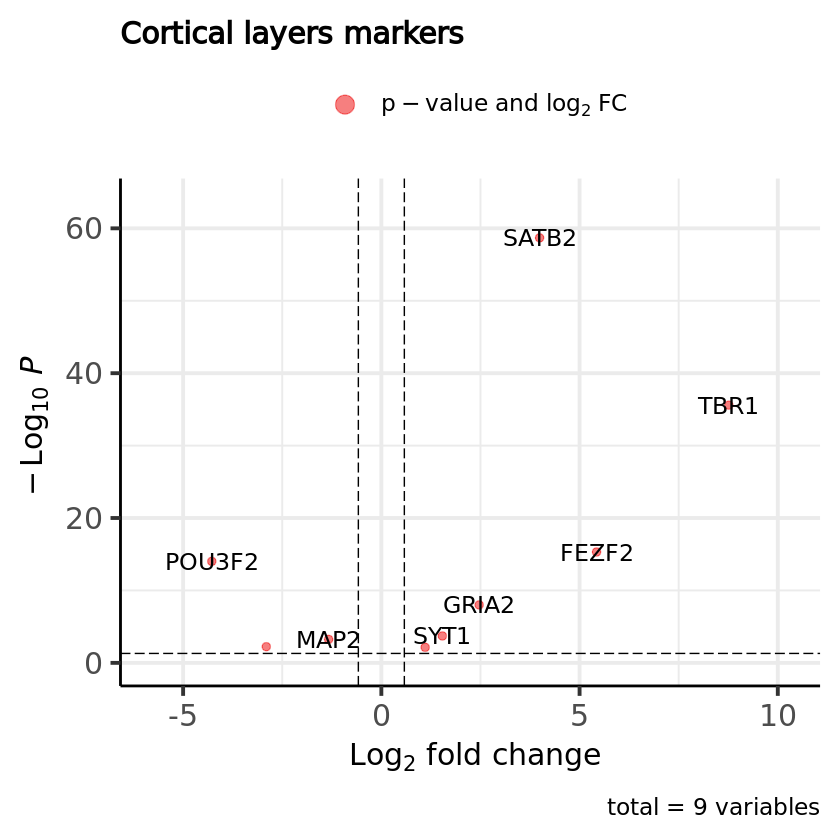

In [122]:
p1 <- EnhancedVolcano(cortical,
        lab = cortical$SYMBOL, 
        x = 'log2FoldChange',
        y = 'padj', 
        title = 'Cortical layers markers',
        subtitle = NULL,
        pCutoff = 0.05, 
        FCcutoff = 0.58)
p1

In [123]:
norm_cortical <- normalized_counts %>%
                filter(gene %in% cortical$gene) %>% column_to_rownames('gene')

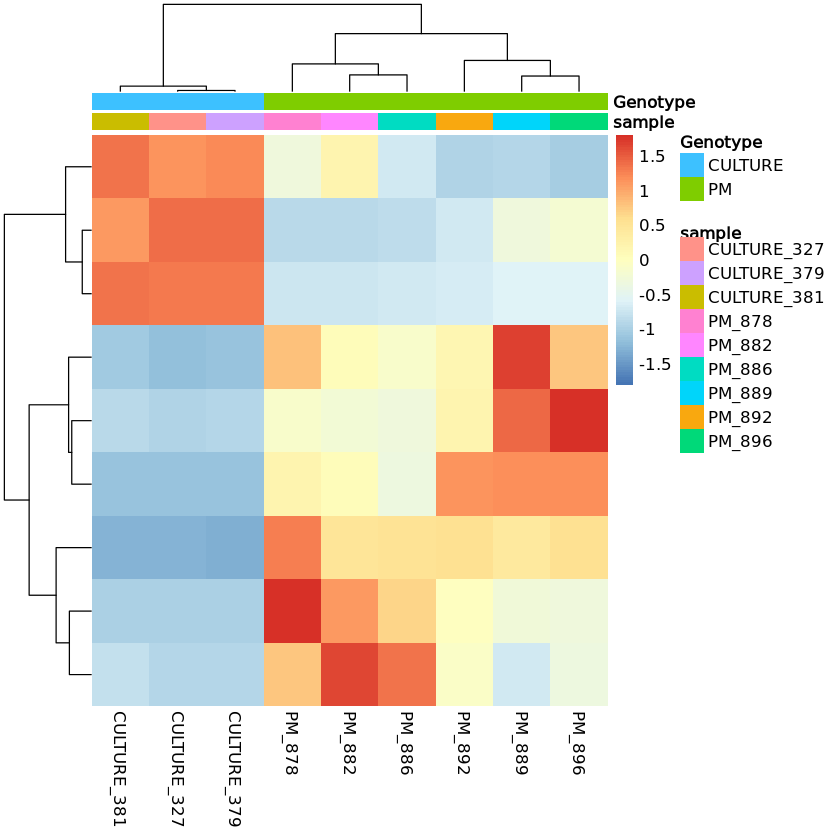

In [124]:
pheatmap(norm_cortical, 
                cluster_rows = T,
                show_rownames = F,
                annotation = meta[,c(1,2)],
                border_color = NA,
                fontsize = 10,
                scale = "row",
                fontsize_row = 10,
                height = 10)

On volcano plots:
We can see that the bigger y-value is, the more probable that post-mortem result is different from culture. The bigger the x-value is, the bigger the contribution of this gene to expression.
Let's remind as markers:
-Deep layers (V–VI): Tbr1, Fezf2, Ctip2<br>

-Upper layers (II–IV): Satb2, Cux1, Pou3f2 (Brn2)

-Pan-neuronal markers: Map2 (maturation), Syt1 (synaptic), Gria2 (glutamatergic)

Pou3f2 and Map2 are seen as significant in culture samples. These results correspond to upper layer and maturation.

Satb2, Tbr1, Fezf2, Gria2, and Syt1 are seen as significant in post-mortem samples. These results correspond to each of category, and probably it is because of a higher heterogenuity in post-mortem samples.

On a heatmap we can clearly see the difference in expression of genes between post-mortem and culture groups.


### Gene Ontology

In [125]:
ego_pm_vs_culture <- enrichGO(gene = sig_pm_vs_culture$gene, 
                    universe = res_pm_vs_culture_tb$gene, 
                    keyType = "ENSEMBL",
                    OrgDb = org.Hs.eg.db, 
                    ont = "BP",
                    pAdjustMethod = "BH", 
                    pvalueCutoff = 0.05)

We use boxplots to visualize the enriched categories:

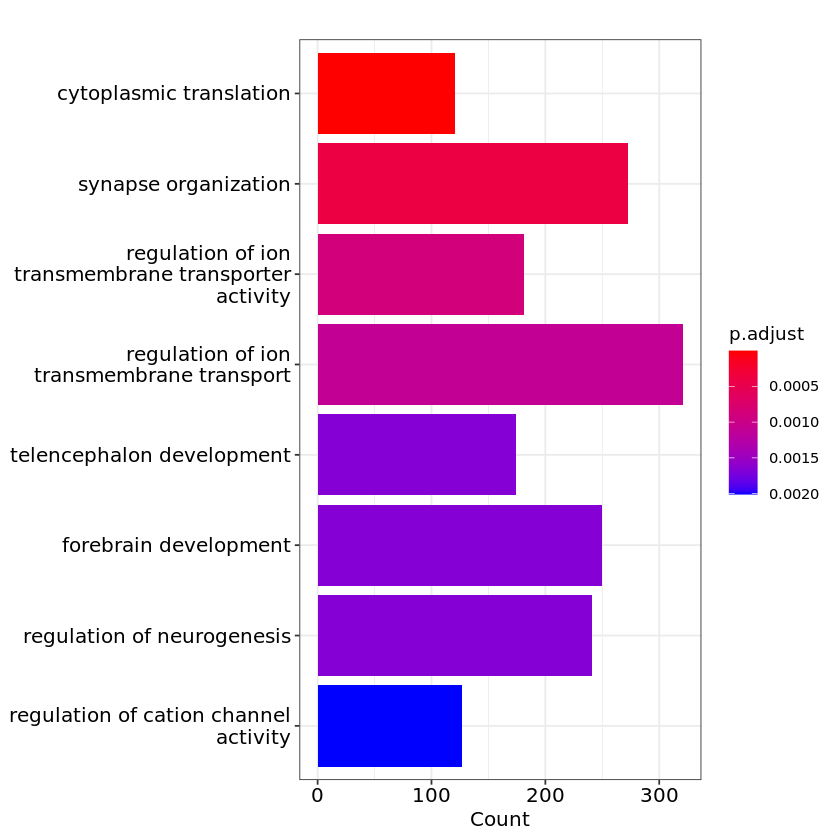

In [126]:
barplot(ego_pm_vs_culture)

### Pathway analysis

In [127]:
.libPaths()

[1] "/home/Veronika.Karpushenko/R/x86_64-conda-linux-gnu-library/4.2"
[2] "/opt/anaconda3/envs/deseq/lib/R/library"

In [130]:
ekegg <- enrichKEGG(gene = na.omit(sig_pm_vs_culture$ENTREZID),
                    organism = 'hsa',
                    pvalueCutoff = 0.05,
                    universe = na.omit(res_pm_vs_culture_tb$ENTREZID), 
                    use_internal_data = T)
## Now the output of the enrichKEGG() is generated, but the Description column consist of NAs. 
## We will add missing pathway names manually from the KEGG.db we just uploaded.

ekegg@result$Description <- unlist(as.list("KEGG.db"::"KEGGPATHID2NAME")[ekegg@result$ID])

In [131]:
ekegg@result$Description <- sub(" - Homo sapiens \\(human\\)", "", ekegg@result$Description)

In [132]:
library(enrichplot)

In [133]:
ups <- enrichplot::upsetplot(ekegg)

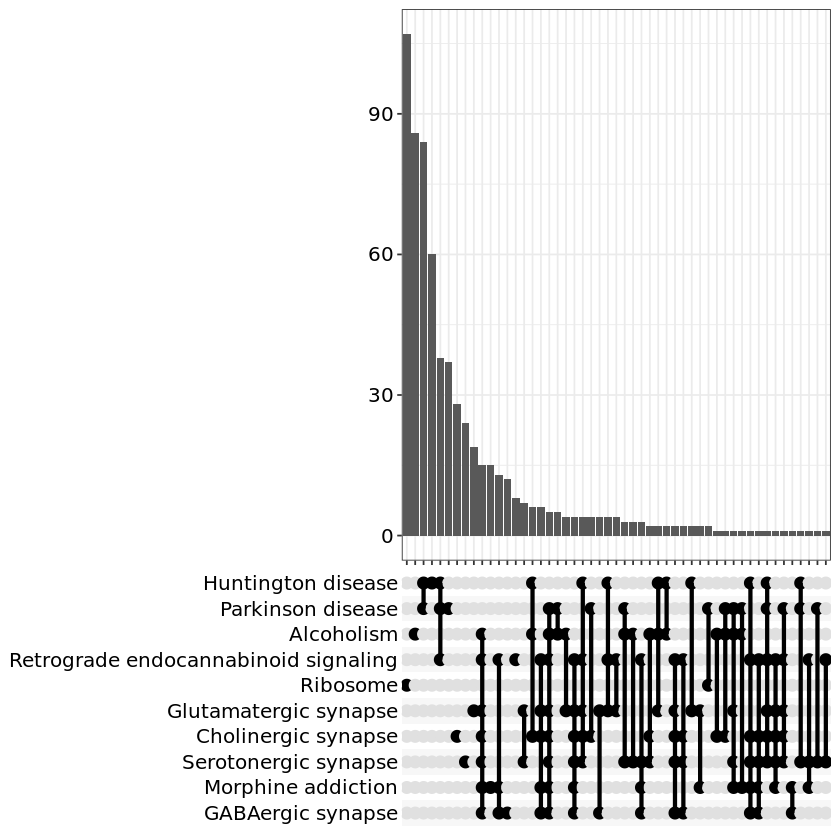

In [134]:
ups

### Gene-Set Enrichment Analysis (GSEA)

In [135]:
filtered <- filter(res_pm_vs_culture_tb, ENTREZID != "NA")

In [136]:
foldchanges <- filtered$log2FoldChange
names(foldchanges) <- as.character(filtered$ENTREZID)

In [137]:
foldchanges <- sort(foldchanges, decreasing = TRUE)

In [138]:
## KEEG.db is already loaded

gseaKEGG <- gseKEGG(geneList = foldchanges,              
                    pAdjustMethod = "fdr",
                    organism = "hsa", 
                    nPerm = 2000, 
                    minGSSize = 10, 
                    pvalueCutoff = 0.05, 
                    verbose = FALSE, 
                    seed = TRUE, 
                    use_internal_data = T)

gseaKEGG@result$Description <- unlist(as.list("KEGG.db"::"KEGGPATHID2NAME")[gseaKEGG@result$ID])

In [139]:
gseaKEGG@result$Description <- sub(" - Homo sapiens \\(human\\)", "", gseaKEGG@result$Description)

In [140]:
datatable(gseaKEGG@result)

HTML widgets cannot be represented in plain text (need html)

Below is a GSEA plot for three manually selected enriched pathway:

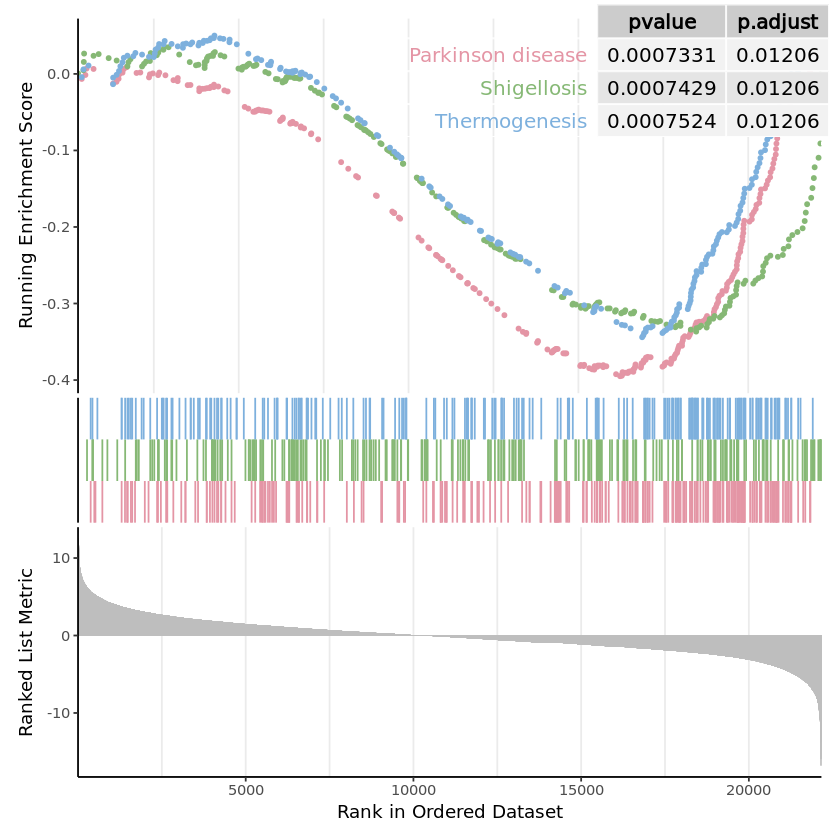

In [144]:
enrichplot::gseaplot2(gseaKEGG, geneSetID = c("hsa05012", "hsa05131", "hsa04714"), pvalue_table = TRUE,
          color = c("#E495A5", "#86B875", "#7DB0DD"), ES_geom = "dot")

### Gene Set Enrichment Analysis with mSigDB

In [147]:
msig_h <- msigdbr(species = "human", category = "H")

In [148]:
msigdbr_t2g <- msig_h %>%
  dplyr::distinct(gs_name, ensembl_gene) %>%
  as.data.frame()

In [149]:
datatable(head(msigdbr_t2g))

HTML widgets cannot be represented in plain text (need html)

In [150]:
hallmarks <- enricher(gene = sig_pm_vs_culture$gene, TERM2GENE = msigdbr_t2g)

Let's visualize the obtained enriched terms

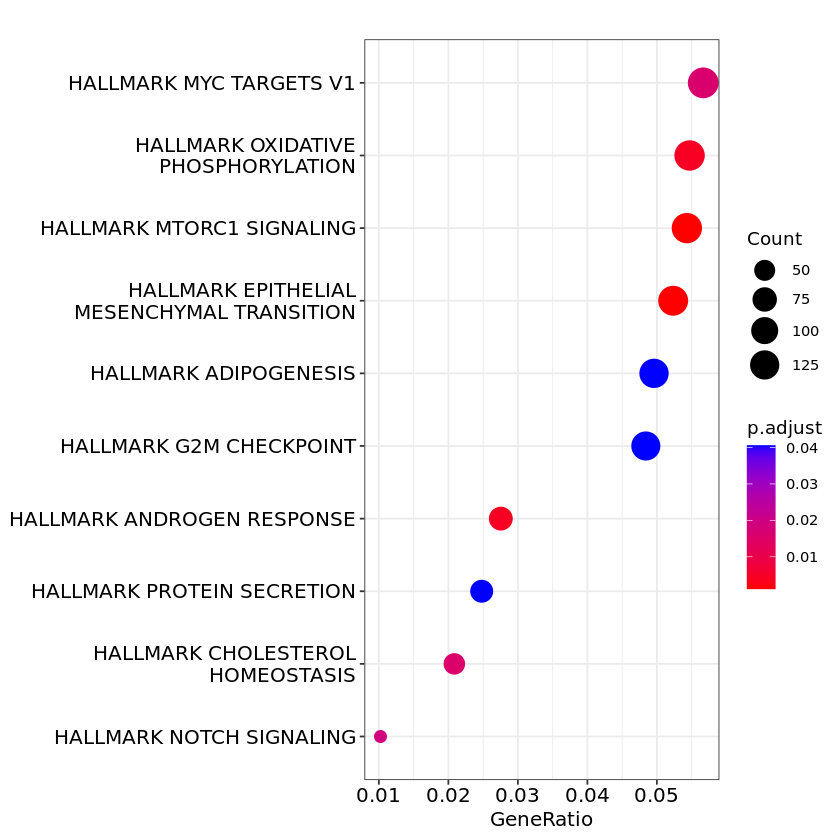

In [151]:
dotplot(hallmarks)

In [152]:
msigdbr_t2g <- msig_h %>%
  dplyr::distinct(gs_name, entrez_gene)

In [153]:
gsea_h <- GSEA(foldchanges, TERM2GENE = msigdbr_t2g)

preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...



In [154]:
datatable(head(gsea_h))

HTML widgets cannot be represented in plain text (need html)

### Perform GSEA on fold change lists using cortical layer marker genes as the gene set

We make term2gene data frame where the first column corresponds to unique term name ("cortical markers") and the second column consists of cortical markers entrez ids.

In [155]:
genes <- c('TBR1', 'FEZF2', 'CTIP2', 'SATB2', 'CUX1', 'POU3F2', 'BRN2', 'MAP2', 'SYT1', 'HEXB', 'CST3', 'GRIA2')
genes_ENTREZID <- filter(map, SYMBOL %in% genes)$ENTREZID
genes_ENTREZID

[1] "3074"  "6857"  "4133"  "1471"  "23314" "2891"  "10716" "55079" "5454" 
[10] "1523"

In [156]:
term2gene <- data.frame(
  term = "CorticalLayerMarkers",
  gene = genes_ENTREZID
)

In [157]:
name2gene <- data.frame(name = genes_filtered, entrez_gene=genes_ENTREZID)
name2gene

name   entrez_gene
1  HEXB   3074       
2  SYT1   6857       
3  MAP2   4133       
4  CST3   1471       
5  SATB2  23314      
6  GRIA2  2891       
7  TBR1   10716      
8  FEZF2  55079      
9  POU3F2 5454       
10 CUX1   1523

In [158]:
head(msigdbr_t2g)
dim(msigdbr_t2g)

gs_name               entrez_gene
1 HALLMARK_ADIPOGENESIS    19      
2 HALLMARK_ADIPOGENESIS 11194      
3 HALLMARK_ADIPOGENESIS 10449      
4 HALLMARK_ADIPOGENESIS    33      
5 HALLMARK_ADIPOGENESIS    34      
6 HALLMARK_ADIPOGENESIS    35

[1] 7321    2

In [159]:
gsea_layer <- GSEA(
  geneList = foldchanges,
  TERM2GENE = term2gene,
  minGSSize = 1,   # as low as possible for small gene sets
  pvalueCutoff = 0.5,  
  verbose = FALSE
)

In [160]:
gsea_layer@result

ID                   Description          setSize
CorticalLayerMarkers CorticalLayerMarkers CorticalLayerMarkers 10     
                     enrichmentScore NES      pvalue    p.adjust  qvalue rank
CorticalLayerMarkers 0.5112816       1.243903 0.2203742 0.2203742 NA     1101
                     leading_edge                  core_enrichment  
CorticalLayerMarkers tags=30%, list=5%, signal=29% 10716/55079/23314

 For cortical layer markers we don't see significant results with GSEA.

Let's perform clustering of DE genes to identify groups of genes with similar expression trends, and perform the enrichment analysis (enrichGO/enrichKEGG) on the groups of our genes.

Hierarchical clustering: https://www.geeksforgeeks.org/hierarchical-clustering-in-r-programming/

In [161]:
# finding distance matrix
distance_mat <- dist(norm_sig_pm_vs_culture, method = 'manhattan')
#distance_mat
 
# fitting Hierarchical clustering model 
# to training dataset
set.seed(240)  # Setting seed
Hierar_cl <- hclust(distance_mat, method = "ward.D2")
Hierar_cl


Call:
hclust(d = distance_mat, method = "ward.D2")

Cluster method   : ward.D2 
Distance         : manhattan 
Number of objects: 12971 


fit
    1     2     3     4 
12747   217     5     2 

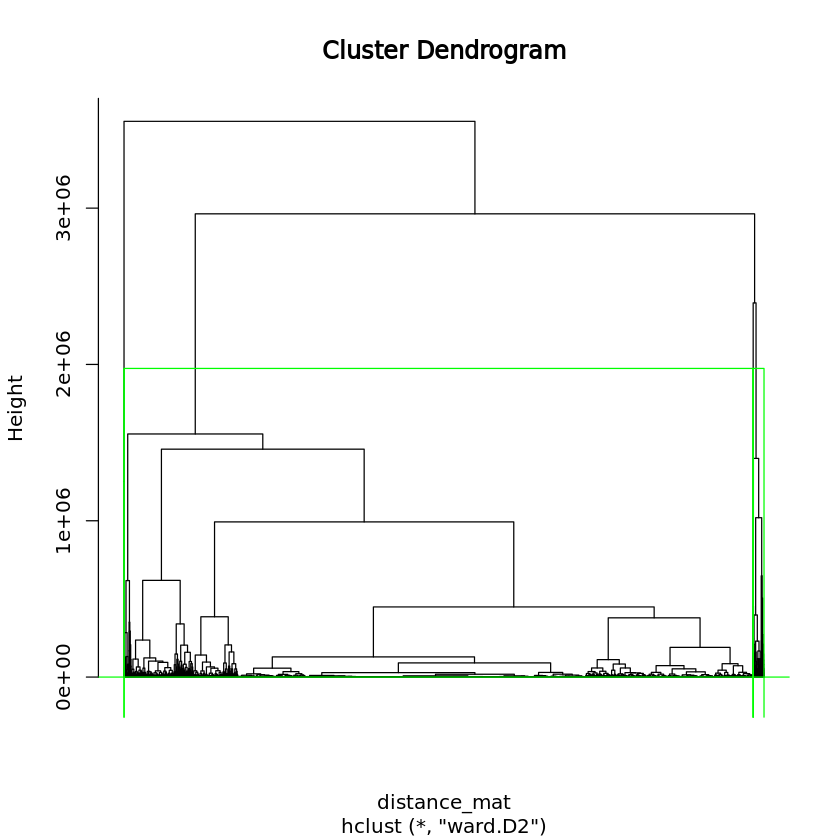

In [162]:
# plotting dendrogram
plot(Hierar_cl, hang = -1, labels = FALSE)

# choosing no. of clusters
# cutting tree by height
abline(h = 3, col = "green")

# cutting tree by no. of clusters
fit <- cutree(Hierar_cl, k = 4 )
#fit
 
table(fit)
rect.hclust(Hierar_cl, k = 4, border = "green")

So, probably we can see 3 distinct clusters at least. Let's check:

Code for k-means and silhouette: https://uc-r.github.io/kmeans_clustering

In [168]:
k2 <- kmeans(norm_sig_pm_vs_culture, centers = 2, nstart = 25)
str(k2)

List of 9
 $ cluster     : Named int [1:12971] 2 2 2 2 2 2 2 2 2 2 ...
  ..- attr(*, "names")= chr [1:12971] "ENSG00000000003" "ENSG00000000419" "ENSG00000000457" "ENSG00000000460" ...
 $ centers     : num [1:2, 1:9] 44370 1312 46373 1340 44197 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:2] "1" "2"
  .. ..$ : chr [1:9] "CULTURE_327" "CULTURE_381" "CULTURE_379" "PM_878" ...
 $ totss       : num 4.19e+12
 $ withinss    : num [1:2] 1.86e+12 1.22e+12
 $ tot.withinss: num 3.08e+12
 $ betweenss   : num 1.11e+12
 $ size        : int [1:2] 36 12935
 $ iter        : int 1
 $ ifault      : int 0
 - attr(*, "class")= chr "kmeans"


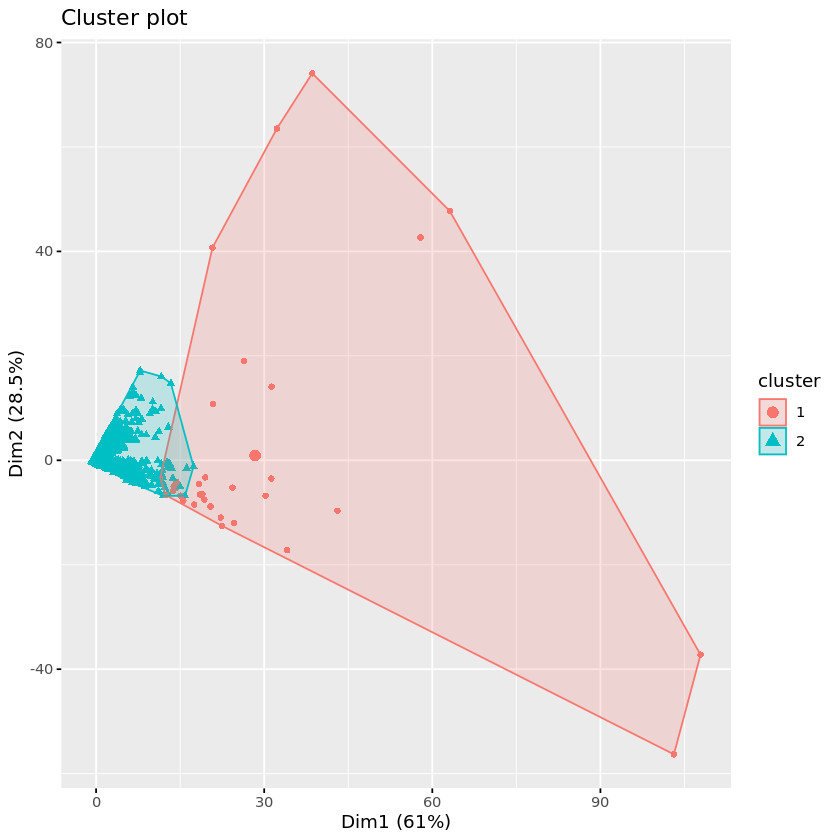

In [169]:
fviz_cluster(k2, data = norm_sig_pm_vs_culture, labelsize = 0) #I' ve hidden labels as they were interfering


Attaching package: ‘gridExtra’


The following object is masked from ‘package:Biobase’:

    combine


The following object is masked from ‘package:BiocGenerics’:

    combine


The following object is masked from ‘package:dplyr’:

    combine




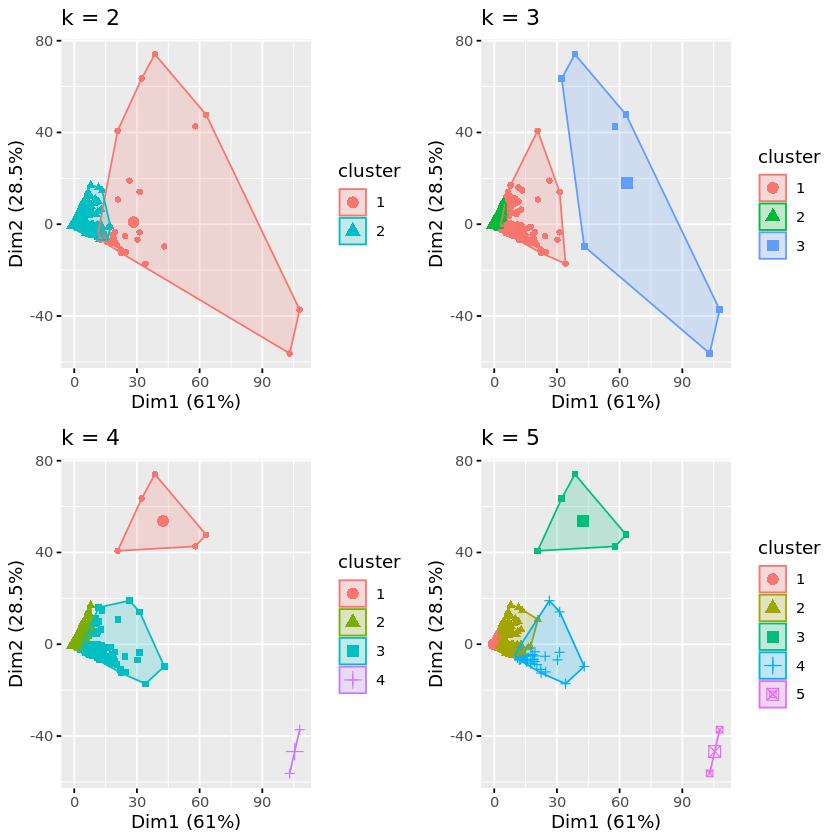

In [170]:
k3 <- kmeans(norm_sig_pm_vs_culture, centers = 3, nstart = 25)
k4 <- kmeans(norm_sig_pm_vs_culture, centers = 4, nstart = 25)
k5 <- kmeans(norm_sig_pm_vs_culture, centers = 5, nstart = 25)

# plots to compare
p1 <- fviz_cluster(k2, geom = "point", data = norm_sig_pm_vs_culture) + ggtitle("k = 2")
p2 <- fviz_cluster(k3, geom = "point",  data = norm_sig_pm_vs_culture) + ggtitle("k = 3")
p3 <- fviz_cluster(k4, geom = "point",  data = norm_sig_pm_vs_culture) + ggtitle("k = 4")
p4 <- fviz_cluster(k5, geom = "point",  data = norm_sig_pm_vs_culture) + ggtitle("k = 5")

library(gridExtra)
grid.arrange(p1, p2, p3, p4, nrow = 2)

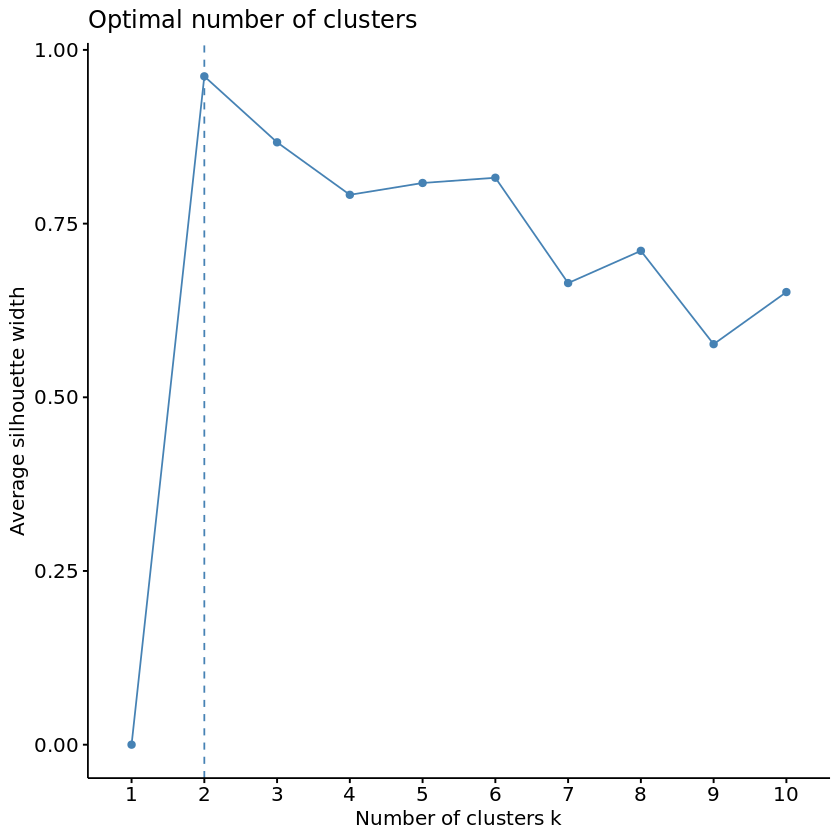

In [171]:
fviz_nbclust(norm_sig_pm_vs_culture, kmeans, method = "silhouette")

So, according to silhouette the most proabable number of clusters is 2.

enrichGO

In [172]:
changed <- tibble::rownames_to_column(norm_sig_pm_vs_culture, var = "gene")

In [173]:
head(changed)

gene            CULTURE_327 CULTURE_381 CULTURE_379 PM_878    PM_882   
1 ENSG00000000003 1315.1218   1311.7094   1387.0062   105.47461  27.12929
2 ENSG00000000419 1981.3614   2015.8389   2096.5736   592.89667 656.13703
3 ENSG00000000457 1411.1584   1444.2429   1262.5745   734.89555 584.22999
4 ENSG00000000460  824.2443    818.9478    875.4805   536.18425 487.95587
5 ENSG00000001036 1293.1686   1238.0488   1466.0557    44.55863 122.39913
6 ENSG00000001084  974.6457   1377.7342    945.0904   475.48029 465.50208
  PM_886   PM_889   PM_892    PM_896  
1 249.5871 172.3374 341.57374 242.6915
2 861.6150 771.3531 918.14606 682.1173
3 451.4038 610.2279 325.47883 735.4258
4 411.5879 324.3556 282.76720 278.2319
5 101.1396 170.5701  84.63007 308.8916
6 642.9037 744.7011 461.74628 995.6760

In [174]:
ego_sig <- enrichGO(gene = changed$gene,
                                universe = res_pm_vs_culture_tb$gene, 
                                keyType = "ENSEMBL",
                                OrgDb = org.Hs.eg.db, 
                                ont = "BP",
                                pAdjustMethod = "BH", 
                                pvalueCutoff = 0.05)

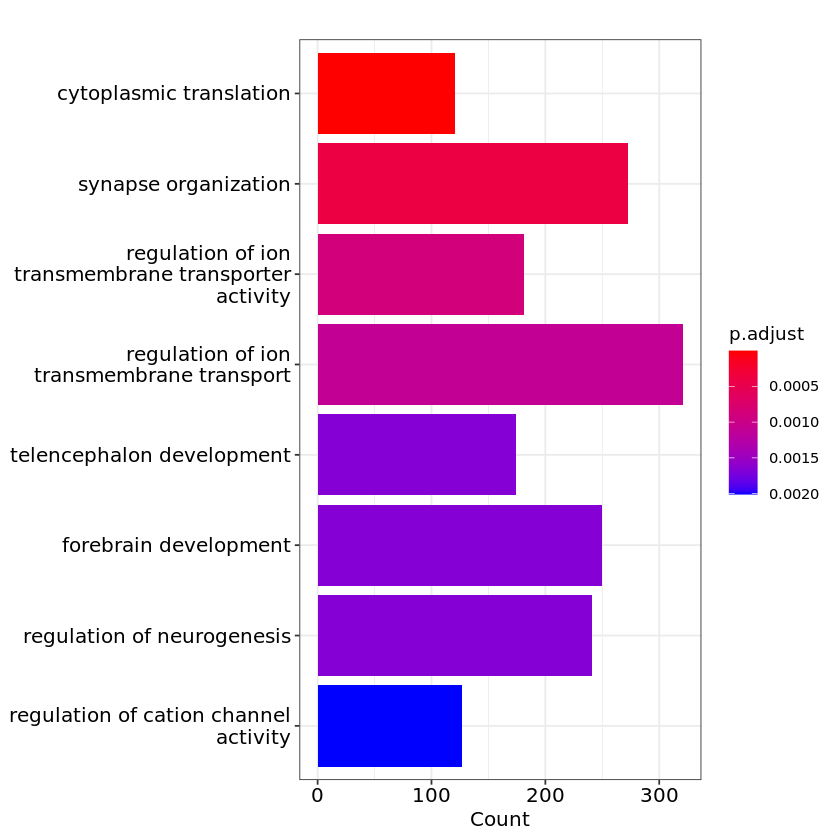

In [175]:
barplot(ego_sig)

Okay, let's do the same for cortical layer markers

In [176]:
# finding distance matrix
distance_mat <- dist(norm_cortical, method = 'manhattan')
#distance_mat
 
# fitting hierarchical clustering model 
# to training dataset
set.seed(240)  # setting seed
Hierar_cl <- hclust(distance_mat, method = "ward.D2")
Hierar_cl



Call:
hclust(d = distance_mat, method = "ward.D2")

Cluster method   : ward.D2 
Distance         : manhattan 
Number of objects: 9 


fit
1 2 3 4 
1 1 6 1 

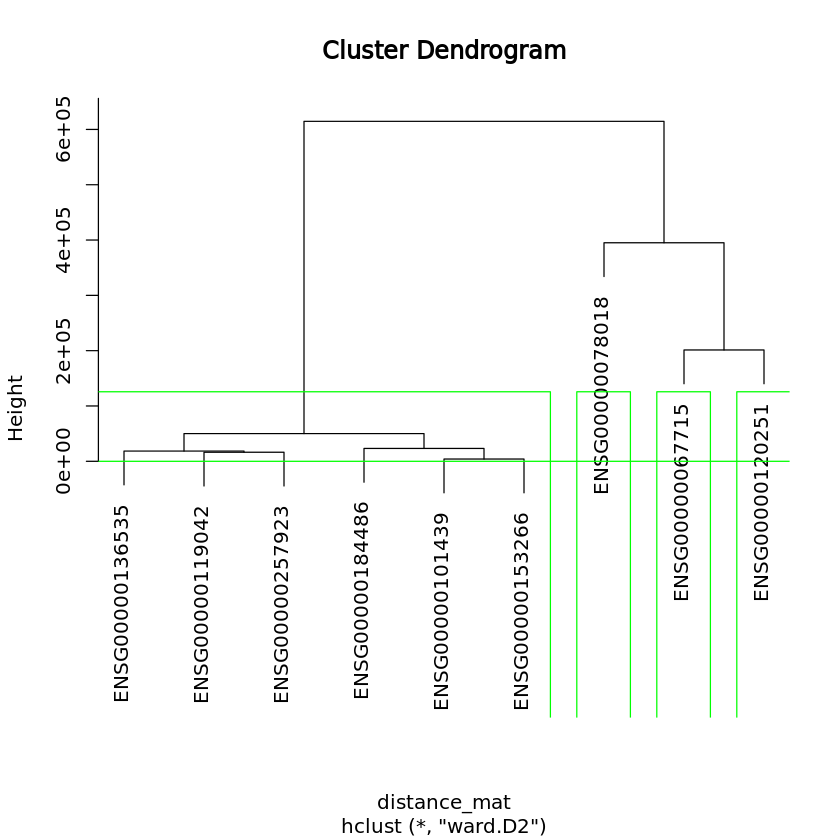

In [177]:
# plotting dendrogram
plot(Hierar_cl)

# choosing no. of clusters
# cutting tree by height
abline(h = 3, col = "green")

# cutting tree by no. of clusters
fit <- cutree(Hierar_cl, k = 4 )
#fit
 
table(fit)
rect.hclust(Hierar_cl, k = 4, border = "green")

In [178]:
k2 <- kmeans(norm_cortical, centers = 2, nstart = 25)
str(k2)

List of 9
 $ cluster     : Named int [1:9] 1 2 1 1 2 1 1 1 1
  ..- attr(*, "names")= chr [1:9] "ENSG00000067715" "ENSG00000078018" "ENSG00000101439" "ENSG00000119042" ...
 $ centers     : num [1:2, 1:9] 3016 49957 3131 53411 3042 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:2] "1" "2"
  .. ..$ : chr [1:9] "CULTURE_327" "CULTURE_381" "CULTURE_379" "PM_878" ...
 $ totss       : num 4.54e+10
 $ withinss    : num [1:2] 6.54e+09 1.20e+10
 $ tot.withinss: num 1.85e+10
 $ betweenss   : num 2.68e+10
 $ size        : int [1:2] 7 2
 $ iter        : int 1
 $ ifault      : int 0
 - attr(*, "class")= chr "kmeans"


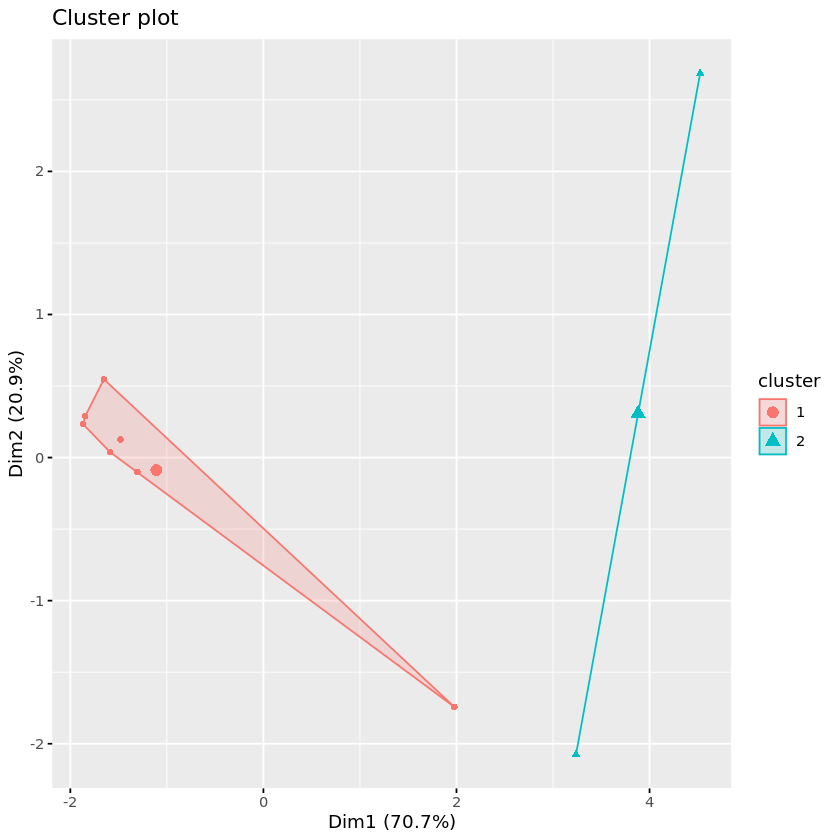

In [179]:
fviz_cluster(k2, data = norm_cortical, labelsize = 0)

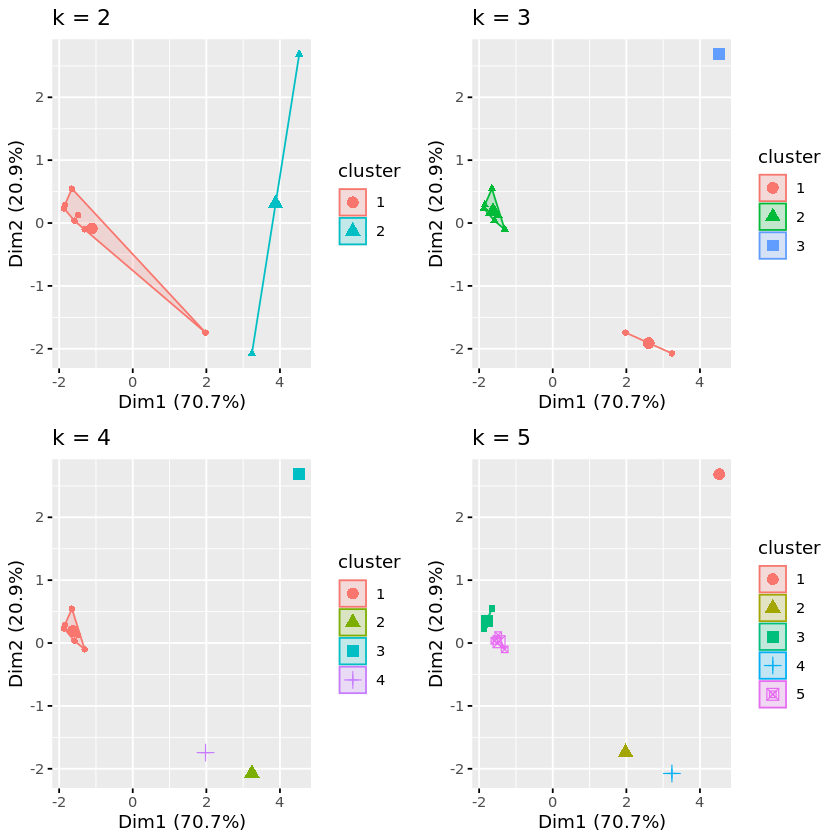

In [180]:
k3 <- kmeans(norm_cortical, centers = 3, nstart = 25)
k4 <- kmeans(norm_cortical, centers = 4, nstart = 25)
k5 <- kmeans(norm_cortical, centers = 5, nstart = 25)

# plots to compare
p1 <- fviz_cluster(k2, geom = "point", data = norm_cortical) + ggtitle("k = 2")
p2 <- fviz_cluster(k3, geom = "point",  data = norm_cortical) + ggtitle("k = 3")
p3 <- fviz_cluster(k4, geom = "point",  data = norm_cortical) + ggtitle("k = 4")
p4 <- fviz_cluster(k5, geom = "point",  data = norm_cortical) + ggtitle("k = 5")

grid.arrange(p1, p2, p3, p4, nrow = 2)

In [181]:
dim(norm_cortical)

[1] 9 9

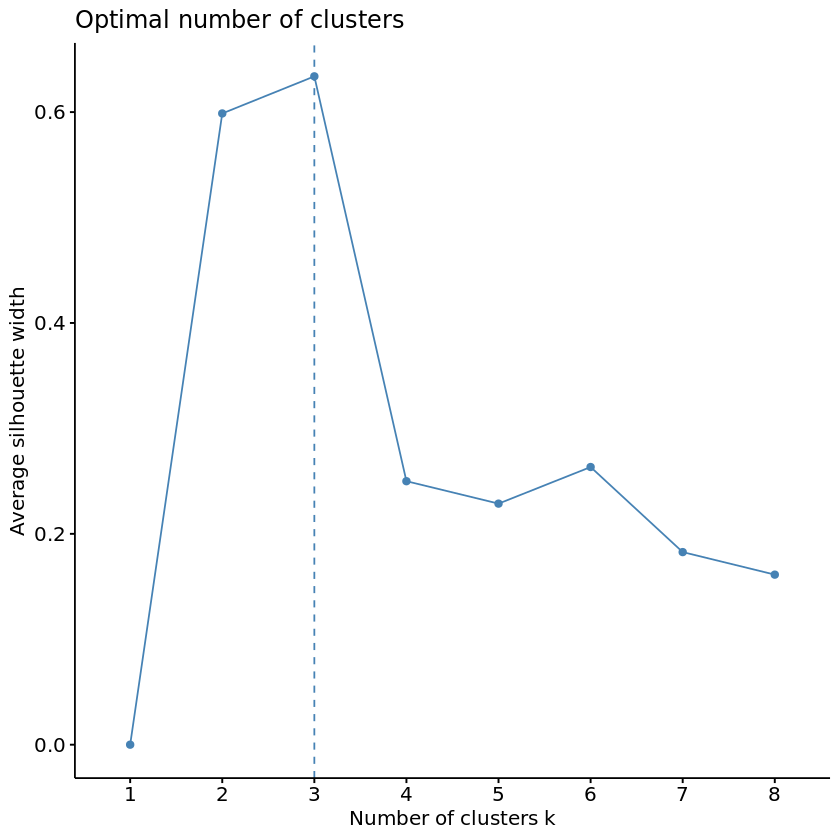

In [182]:
fviz_nbclust(norm_cortical, kmeans, method = "silhouette", k.max = 8)

So for cortical layer markers it's also most probable 3 clusters

In [183]:
changed_cortical <- tibble::rownames_to_column(norm_cortical, var = "gene")

In [184]:
ego_cortical <- enrichGO(gene = changed_cortical$gene,
                                universe = res_pm_vs_culture_tb$gene, 
                                keyType = "ENSEMBL",
                                OrgDb = org.Hs.eg.db, 
                                ont = "BP",
                                pAdjustMethod = "BH", 
                                pvalueCutoff = 0.05)

The enriched categories for cortical layer markers (sanity check):

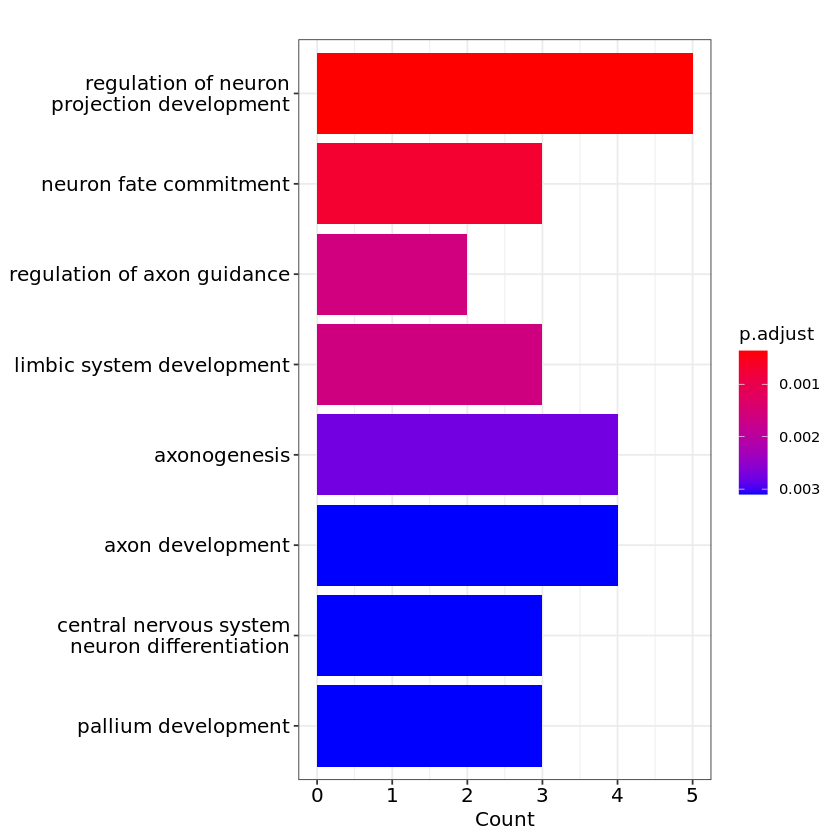

In [185]:
barplot(ego_cortical)